In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
# the hrf model to be used for data constructions
from nistats.hemodynamic_models import spm_hrf
# compute betaseries correlations
from nibetaseries.interfaces.nistats import BetaSeries
# make AR(1) correlated error terms
from statsmodels.tsa.arima_process import ArmaProcess
# generate optimal experimental designs
from neurodesign import optimisation,experiment
# make correlated betas
from scipy.linalg import cholesky
# numerical operations
import numpy as np
# convient to create tsvs
import pandas as pd
# create/operate on nifti images
import nibabel as nib

/home/james/.conda/envs/beta_sim/lib/python3.6/site-packages/duecredit/utils.py:32: PendingDeprecationWarning: dist() and linux_distribution() functions are deprecated in Python 3.5
  and platform.linux_distribution()[0] == 'debian' \
/home/james/.conda/envs/beta_sim/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/james/.conda/envs/beta_sim/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/james/.conda/envs/beta_sim/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


# Beta Series Simulations

Testing [NiBetaSeries](https://github.com/HBClab/NiBetaSeries) with 

In [2]:
# repetition time of the MRI image
tr = 2
# number of experimental trials
n_trials = 80
# number of trial types (elijah wood and daniel radcliff)
n_trialtypes = 2
# minimum intertrial interval
iti_min = 3.5
# mean intertrial interval
iti_mean = 10
# maximum intertrial interval
iti_max = 20
# how to sample itis (mostly small, but a few larger ones)
iti_model = 'exponential'
# how long the stimulus is presented
stim_duration = 0.2
# stimulus probability (each stimulus is equally likely to occur)
stim_prob = [1 / n_trialtypes] * n_trialtypes
# contrasts of interest (dependent on n_trialtypes)
contrasts = [[1, 0], [0, 1], [1, -1]]
# resolution for the data generation process
des_res = 0.1
# autocorrelation for data
rho = 0.12
# set random seed for reproducibility
np.random.seed(12345)

In [3]:
Experiment = experiment(
    TR=tr,
    n_trials=n_trials,
    P=stim_prob,
    C=contrasts,
    n_stimuli=n_trialtypes,
    rho=rho,
    resolution=des_res,
    stim_duration=stim_duration,
    ITImodel=iti_model,
    ITImin=iti_min,
    ITImean=iti_mean,
    ITImax=iti_max
    )

/home/james/.conda/envs/beta_sim/lib/python3.6/site-packages/neurodesign/classes.py:410: UserWarning: Warning: the resolution is adjusted to be a multiple of the TR.  New resolution: 0.100000
  warnings.warn("Warning: the resolution is adjusted to be a multiple of the TR.  New resolution: %f"%self.resolution)
/home/james/.conda/envs/beta_sim/lib/python3.6/site-packages/neurodesign/classes.py:560: RuntimeWarning: divide by zero encountered in log
  res = (h - 1) * np.log(s) + h * np.log(l) - l * s - np.log(gamma(h))


In [4]:
# find best design
Designer = optimisation(
    experiment=Experiment,
    weights=[0, 0.25, 0.5, 0.25],
    preruncycles=2,
    cycles=100,
    optimisation='GA'
    )

Designer.optimise()

100% |########################################################################|
100% |########################################################################|


In [5]:
# cannot use PopMax.bestdesign.Xnonconv because resolution information is lost
# (if I care about testing jitter)

In [6]:
# https://quantcorner.wordpress.com/2018/02/09/generation-of-correlated-random-numbers-using-python/
# mean of the betas pulled from Mumford (2012) (hard coded!)
betas_mean = [5.0, 5.0, 5.0, 5.0]
# standard deviation for the betas (hard coded!)
betas_sd = [0.5, 0.5, 0.5, 0.5]
# beta network correlation for seeing elijah wood
wcorr_ew = 0.8
# beta network correlation for seeing daniel radcliff
wcorr_dr = 0.4
# the correlation between the elijah wood and daniel radcliff networks
bcorr = 0.0
# the number of trials per trial type
beta_matrix_rows = int(n_trials / n_trialtypes)
# the number of voxels to simulate
n_voxels = 2
# each trial type gets a column for each voxel
beta_matrix_columns = int(n_trialtypes * n_voxels)

# full correlation matrix (hard coded!)
corr_mat = np.array([[1.0, wcorr_ew, bcorr, bcorr],
                     [wcorr_ew, 1.0, bcorr, bcorr],
                     [bcorr, bcorr, 1.0, wcorr_dr],
                     [bcorr, bcorr, wcorr_dr, 1.0]])

# compute the (upper) Cholesky decomposition matrix
upper_chol = cholesky(corr_mat)

# generate random betas
rnd = np.random.normal(betas_mean, betas_sd,
                       size=(beta_matrix_rows, beta_matrix_columns))

# finally, compute the inner product of upper_chol and rnd
betas = rnd @ upper_chol

# see how closely generated data matches assumptions
ground_truth = np.corrcoef(betas.T)

# elijah wood's ground truth beta correlation (hard coded!)
truth_ew = ground_truth[0, 1]
# daniel radcliff's ground truth beta correlation (hard coded!)
truth_dr = ground_truth[2, 3]
print('Elijah Wood within network correlation:     {}'.format(truth_ew))
print('Daniel Radcliff within network correlation: {}'.format(truth_dr))

Elijah Wood within network correlation:     0.7648639577549889
Daniel Radcliff within network correlation: 0.3500235750233779


In [10]:
# function to round to nearest even number (no jitter inside resolution of tr)
# only works as expected if tr is 2
def round_to_even(arr):
    """
    rounds all entries in numpy array to nearest even number
    """
    tmp_arr = arr / 2
    return tmp_arr.astype(int) * 2

cond_order = Designer.bestdesign.order
# divide by design resolution to have same resolution as experiment generation process
onsets = Designer.bestdesign.onsets / des_res
onsets = onsets.astype(int)
# make onsets that are locked to tr (no jitter)
onsets_nj = round_to_even(Designer.bestdesign.onsets) / des_res
onsets_nj = onsets_nj.astype(int)
# allocate design matrix (one column per trial)
X = np.zeros((int(Designer.bestdesign.experiment.duration / des_res), onsets.shape[0]))
X_nj = np.zeros((int(Designer.bestdesign.experiment.duration / des_res), onsets.shape[0]))
# allocate betas (two columns for 2 voxels)
B = np.zeros((onsets.shape[0], 2))
# the stimulus duration represented in the design resolution
stim_duration_msec = int(stim_duration / des_res)
# oversampling at the rate of the design resolution
sampling_rate = int(tr / des_res)
# counters for elijah wood and daniel radcliff stimuli
cond_ew = 0
cond_dr = 0

# create the design matrix for the data generation process
for idx, (cond, onset, onset_nj) in enumerate(zip(cond_order, onsets, onsets_nj)):
    # set the design matrix
    X[onset:onset+stim_duration_msec, idx] = 1
    X[:, idx] = np.convolve(X[:, idx], spm_hrf(tr, oversampling=sampling_rate))[0:X.shape[0]]
    X_nj[onset_nj:onset_nj+stim_duration_msec, idx] = 1
    X_nj[:, idx] = np.convolve(X_nj[:, idx], spm_hrf(tr, oversampling=sampling_rate))[0:X_nj.shape[0]]
    # set the beta for the trial depending on condition
    if cond == 0:
        B[idx, :] = betas[cond_ew, 0:2]
        cond_ew += 1
    elif cond == 1:
        B[idx, :] = betas[cond_dr, 2:4]
        cond_dr += 1

# downsample X so it's back to TR resolution
X = X[::sampling_rate, :]
X_nj = X_nj[::sampling_rate, :]

In [11]:
n_trs = int(Designer.bestdesign.experiment.duration / tr)

In [12]:
# AR(1) process with 1 lag with a .12 correlation (Mumford et al. 2012)
sd_err = 0.04
ar = np.array([1, -rho])
ap = ArmaProcess(ar)
err = ap.generate_sample((n_trs, 2), scale=sd_err, axis=0)

In [13]:
Y = X @ B + err
Y_nj = X_nj @ B + err

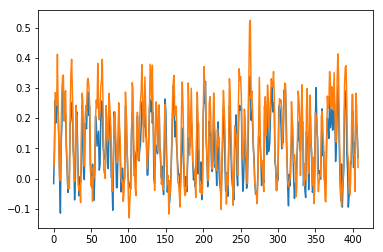

In [14]:
plt.plot(Y)

In [16]:
# Make events file
events_file = 'events.tsv'
events_nj_file = 'events_nj.tsv'
collector = {'onset': [], 
             'duration': [], 
             'correct': [],
             'trial_type': []}
collector_nj = {'onset': [], 
                'duration': [], 
                'correct': [],
                'trial_type': []}
for cond, onset, onset_nj in zip(cond_order, onsets, onsets_nj):
    if cond == 0:
        collector['trial_type'].append('elijah_wood')
        collector_nj['trial_type'].append('elijah_wood')
    elif cond == 1:
        collector['trial_type'].append('daniel_radcliffe')
        collector_nj['trial_type'].append('daniel_radcliffe')

    collector['onset'].append(onset * des_res)
    collector['duration'].append(stim_duration)
    collector['correct'].append(1)
    
    collector_nj['onset'].append(onset_nj * des_res)
    collector_nj['duration'].append(stim_duration)
    collector_nj['correct'].append(1)

events_df = pd.DataFrame.from_dict(collector)
events_df.to_csv(events_file, sep='\t', index=False)

events_nj_df = pd.DataFrame.from_dict(collector_nj)
events_nj_df.to_csv(events_nj_file, sep='\t', index=False)

In [17]:
# create bold nifti
bold_file = 'bold_file.nii.gz'
bold_data = np.array([[Y.T]])
bold_img = nib.Nifti1Image(bold_data, np.eye(4))
bold_img.to_filename(bold_file)

# create bold (no jitter) nifti
bold_nj_file = 'bold_nj_file.nii.gz'
bold_nj_data = np.array([[Y_nj.T]])
bold_nj_img = nib.Nifti1Image(bold_nj_data, np.eye(4))
bold_nj_img.to_filename(bold_nj_file)

# create mask nifti
mask_file = 'brainmask.nii.gz'
mask_data = np.array([[[1, 1]]], dtype=np.int16)
mask_img = nib.Nifti1Image(mask_data, np.eye(4))
mask_img.to_filename(mask_file)

In [18]:
# bold_metadata
bold_metadata = {"RepetitionTime": tr, "TaskName": "whodis"}

In [19]:
beta_series = BetaSeries(bold_file=bold_file,
                         bold_metadata=bold_metadata,
                         confounds_file=None,
                         events_file=events_file,
                         hrf_model='spm',
                         low_pass=None,
                         mask_file=mask_file,
                         selected_confounds=None,
                         smoothing_kernel=None)

beta_series_nj = BetaSeries(bold_file=bold_nj_file,
                            bold_metadata=bold_metadata,
                            confounds_file=None,
                            events_file=events_nj_file,
                            hrf_model='spm',
                            low_pass=None,
                            mask_file=mask_file,
                            selected_confounds=None,
                            smoothing_kernel=None)

In [20]:
result = beta_series.run()
result_nj = beta_series_nj.run()

Computing run 1 out of 1 runs (go take a coffee, a big one)
/home/james/.conda/envs/beta_sim/lib/python3.6/site-packages/nistats/hemodynamic_models.py:268: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  frame_times.max() * (1 + 1. / (n - 1)), n_hr)
/home/james/.conda/envs/beta_sim/lib/python3.6/site-packages/nistats/hemodynamic_models.py:55: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  time_stamps = np.linspace(0, time_length, float(time_length) / dt)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs don


Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a


Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds



In [21]:
result.outputs.beta_maps

['/media/Data/Documents/devel/betaSim/betaseries_trialtype-daniel_radcliffe.nii.gz',
 '/media/Data/Documents/devel/betaSim/betaseries_trialtype-elijah_wood.nii.gz']

In [22]:
for bmap in result.outputs.beta_maps:
    if 'elijah_wood' in bmap:
        bm_ew = nib.load(bmap)
    elif 'daniel_radcliffe' in bmap:
        bm_dr = nib.load(bmap)
        
for bmap_nj in result_nj.outputs.beta_maps:
    if 'elijah_wood' in bmap_nj:
        bm_nj_ew = nib.load(bmap_nj)
    elif 'daniel_radcliffe' in bmap_nj:
        bm_nj_dr = nib.load(bmap_nj)

In [23]:
betas_ew = np.squeeze(bm_ew.get_data())
betas_dr = np.squeeze(bm_dr.get_data())

betas_nj_ew = np.squeeze(bm_nj_ew.get_data())
betas_nj_dr = np.squeeze(bm_nj_dr.get_data())

In [24]:
np.corrcoef(betas_dr)

array([[1.        , 0.22661763],
       [0.22661763, 1.        ]])

In [25]:
np.corrcoef(betas_nj_dr)

array([[1.        , 0.22661763],
       [0.22661763, 1.        ]])

In [26]:
np.corrcoef(betas_ew)

array([[1.        , 0.42242426],
       [0.42242426, 1.        ]])

In [27]:
np.corrcoef(betas_nj_ew)

array([[1.        , 0.42242426],
       [0.42242426, 1.        ]])

# Simulations

I would like to test the impact of jitter on correlations, the length of the ITI, how much noise is necessary/how to represent noise

(0, 5)

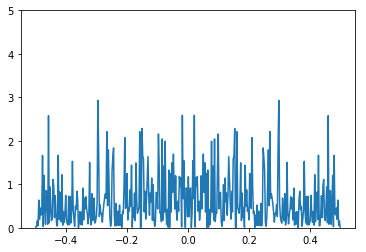

In [28]:
Y_c = X @ B

ps = np.abs(np.fft.fft(err[:,1]))**2
freqs = np.fft.fftfreq(err[:,1].size, 1)
idx = np.argsort(freqs)


f = plt.plot(freqs[idx], ps[idx])
f[0].axes.set_ylim((0, 5))

In [33]:
X_nj == X


array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True, False, False],
       [ True,  True,  True, ...,  True, False, False],
       [ True,  True,  True, ...,  True, False, False]])

In [30]:
np.std(Y[:,1])

0.13293909936316867